In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

/Users/outlawedchop/miniforge3/envs/tf/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data Set Information

![Dota 2](./pudge.jpg)

Dota 2 is a popular computer game with two teams of 5 players. At the start of the game each player chooses a unique hero with different strengths and weaknesses. The dataset is reasonably sparse as only 10 of 113 possible heroes are chosen in a given game. All games were played in a space of 2 hours on the 13th of August, 2016

### Attribute Information:
Each row of the dataset is a single game with the following features (in the order in the vector):
1. Team won the game (1 or -1)
2. Cluster ID (related to location)
3. Game mode (eg All Pick)
4. Game type (eg. Ranked)
5. *till end*: Each element is an indicator for a hero.   
    Value of 1 indicates that a player from team '1' played as that hero and '-1' for the other team.    
    Hero can be selected by only one player each game. This means that each row has five '1' and five '-1' values.

In [2]:
import warnings
from typing import Literal

warnings.filterwarnings('ignore')

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

## Importing dataset

In [4]:
train_df = pd.read_csv('dota2Train.csv', sep=',', header=None)
train_df

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,-1,154,2,3,1,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
92646,1,154,2,2,0,0,0,0,-1,0,...,1,0,0,0,0,0,0,0,0,0
92647,1,111,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92648,-1,185,2,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df = pd.read_csv('dota2Test.csv', sep=',', header=None)
test_df

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-1,223,8,2,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,227,8,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,-1,136,2,2,1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,227,2,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,184,2,3,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10289,1,121,2,2,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
10290,1,154,9,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10291,1,122,9,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10292,1,152,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Importing additional json data

In [6]:
with open('heroes.json') as json_file:
    heroes_data = json.load(json_file)
    
heroes_df = pd.DataFrame.from_dict(heroes_data['heroes']).set_index('id')
heroes_df.sort_index(inplace=True)
heroes_df

,name,localized_name
id,,
1,antimage,Anti-Mage
2,axe,Axe
3,bane,Bane
4,bloodseeker,Bloodseeker
5,crystal_maiden,Crystal Maiden
...,...,...
109,terrorblade,Terrorblade
110,phoenix,Phoenix
111,oracle,Oracle


In [7]:
with open('lobbies.json') as json_file:
    lobbies_data = json.load(json_file)
    
lobbies_df = pd.DataFrame.from_dict(lobbies_data['lobbies']).set_index('id')
lobbies_df.columns = ['lobbie_type']
lobbies_df

,lobbie_type
id,
-1,Invalid
0,Public matchmaking
1,Practice
2,Tournament
3,Tutorial
4,Co-op with bots
5,Team match
6,Solo Queue
7,Ranked


In [8]:
with open('mods.json') as json_file:
    mods_data = json.load(json_file)
    
mods_df = pd.DataFrame.from_dict(mods_data['mods']).set_index('id')
mods_df.columns = ['mode_name']
mods_df

,mode_name
id,
0,Unknown
1,All Pick
2,Captains Mode
3,Random Draft
4,Single Draft
5,All Random
6,?? INTRO/DEATH ??
7,The Diretide
8,Reverse Captains Mode


In [9]:
with open('regions.json') as json_file:
    regions_data = json.load(json_file)
    
regions_df = pd.DataFrame.from_dict(regions_data['regions']).set_index('id')
regions_df.columns = ['region_name']
regions_df.head()

,region_name
id,
111,US West
112,US West
113,US West
114,US West
121,US East


## Data cleaning

**Important Note**:    
> Dota 2 API has no information about the hero with `id=24`     
  This is due to the fact that this character was never released, but changes in the API were not made.    
  So we need to check if this is the case.

In [10]:
len(train_df.columns)

117

In [11]:
heroes_df.count()

name              112
localized_name    112
dtype: int64

As we can see `heroes_df` missing one value (112 + 4 != 117), \
so we need to find it and remove also from the testing and training datasets

In [12]:
set(range(1, len(heroes_df.index) + 1)) - set(heroes_df.index)

{24}

Additionally, let's check if there are any records corresponding to hero with `id=24` and if it is safe to drop this column

In [13]:
train_df.loc[train_df.loc[:, 24 + 3] != 0, 24 + 3].count()

0

In [14]:
test_df.loc[test_df.loc[:, 24 + 3] != 0, 24 + 3].count()

0

In [15]:
train_df.drop(train_df.columns[24 + 3], axis=1, inplace=True)
test_df.drop(test_df.columns[24 + 3], axis=1, inplace=True)

## Merging data into single dataset

In [16]:
df_header = ['team', 'cluster_id', 'game_mode', 'game_type', *list(heroes_df['localized_name'].values)]

In [17]:
train_df.columns = df_header
test_df.columns = df_header

In [18]:
train_df.head(5)

,team,cluster_id,game_mode,game_type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
train_df = train_df.merge(regions_df, left_on='cluster_id', right_index=True).drop('cluster_id', axis=1)
train_df = train_df.merge(mods_df, left_on='game_mode', right_index=True).drop('game_mode', axis=1)
train_df = train_df.merge(lobbies_df, left_on='game_type', right_index=True).drop('game_type', axis=1)

test_df = test_df.merge(regions_df, left_on='cluster_id', right_index=True).drop('cluster_id', axis=1)
test_df = test_df.merge(mods_df, left_on='game_mode', right_index=True).drop('game_mode', axis=1)
test_df = test_df.merge(lobbies_df, left_on='game_type', right_index=True).drop('game_type', axis=1)

In [20]:
new_header = ['team', 'region_name', 'mode_name', 'lobbie_type', *list(heroes_df['localized_name'].values)]

In [21]:
train_df.sort_index(inplace=True)
train_df = train_df.reindex(new_header, axis=1)

test_df.sort_index(inplace=True)
test_df = test_df.reindex(new_header, axis=1)

In [22]:
train_df

,team,region_name,mode_name,lobbie_type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,-1,China,Captains Mode,Tournament,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Southeast Asia,Captains Mode,Tournament,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,Europe West,Captains Mode,Tournament,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,Southeast Asia,Captains Mode,Tournament,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,Australia,Captains Mode,Tutorial,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,-1,Southeast Asia,Captains Mode,Tutorial,1,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
92646,1,Southeast Asia,Captains Mode,Tournament,0,0,0,0,-1,0,...,1,0,0,0,0,0,0,0,0,0
92647,1,US West,Captains Mode,Tutorial,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92648,-1,Russia,Captains Mode,Tournament,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
test_df

,team,region_name,mode_name,lobbie_type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,-1,China,Reverse Captains Mode,Tournament,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,China,Reverse Captains Mode,Tournament,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,-1,Europe West,Captains Mode,Tournament,1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,China,Captains Mode,Tournament,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Russia,Captains Mode,Tutorial,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10289,1,US East,Captains Mode,Tournament,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
10290,1,Southeast Asia,Greeviling,Tournament,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10291,1,US East,Greeviling,Tournament,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10292,1,Southeast Asia,Captains Mode,Tutorial,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Descriptive analytics

## Region analysis

In [24]:
train_df.loc[:, 'region_name':'lobbie_type'].describe(include=['O'])

,region_name,mode_name,lobbie_type
count,90944,90944,90944
unique,14,9,3
top,Southeast Asia,Captains Mode,Tournament
freq,40843,70797,55941


In [25]:
train_df.pivot_table('team', 
                     index='region_name', 
                     columns=['lobbie_type', 'mode_name'], 
                     aggfunc='count',
                     fill_value=0)

lobbie_type             Practice                   Tournament           \
mode_name      ?? INTRO/DEATH ?? Greeviling ?? INTRO/DEATH ?? All Pick   
region_name                                                              
Australia                      0          0                 6       26   
Chile                          0          0                 2        1   
China                          2          1               119      490   
Europe East                    0          0                 3       22   
Europe West                    7          0                14       53   
India                          0          0                 1        1   
Peru                           0          0                 2        0   
Russia                         0          0                24      122   
South Africa                   0          0                 1        1   
South America                  0          0                 2       24   
South Korea                    0          0                13       16   
Southeast Asia                 5          0                46      359   
US East                        0          0                17       31   
US West                        0          0                19       44   

lobbie_type                                                      \
mode_name      All Random Captains Mode Greeviling Random Draft   
region_name                                                       
Australia               0           569         80           11   
Chile                   0           101         13            0   
China                   2          9349        932           43   
Europe East             0           616        330           19   
Europe West             0          1918        891           57   
India                   0           148         52            7   
Peru                    0            81         29            2   
Russia                  7          3714       2057          144   
South Africa            0            87         13            5   
South America           0           637        181            7   
South Korea             0          1255        271           11   
Southeast Asia          3         20211       4764           32   
US East                 0          1051        246           23   
US West                 0           772        107           21   

lobbie_type                                                     \
mode_name      Reverse Captains Mode Single Draft The Diretide   
region_name                                                      
Australia                          6            1            1   
Chile                              4            0            0   
China                           3058          133           40   
Europe East                        8            5            4   
Europe West                       50           12            5   
India                              1            0            0   
Peru                               4            0            1   
Russia                            53           20           12   
South Africa                      10            0            0   
South America                      2            2            1   
South Korea                       19            0            0   
Southeast Asia                    33            7            8   
US East                           48            3            3   
US West                           53            2            4   

lobbie_type             Tutorial                                      
mode_name      ?? INTRO/DEATH ?? Captains Mode Reverse Captains Mode  
region_name                                                           
Australia                      0           420                     2  
Chile                          0             6                     0  
China                         26          5572                  4124  
Europe East                    5           707      

## Heroes analysis

In [26]:
htrain_df = train_df.iloc[:, 4:]
htrain_df

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,-1,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,-1,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,1,0,0,-1,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
92646,0,0,0,0,-1,0,0,-1,0,0,...,1,0,0,0,0,0,0,0,0,0
92647,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
92648,0,0,0,0,0,1,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
heroes_picks = htrain_df.astype(bool).sum(axis=0)
heroes_picks

Anti-Mage         14717
Axe               19851
Bane               2488
Bloodseeker       11534
Crystal Maiden     9920
                  ...  
Terrorblade        4436
Phoenix            3777
Oracle             2588
Winter Wyvern      3273
Arc Warden         1769
Length: 112, dtype: int64

In [28]:
print("Most playable hero:\n", (heroes_picks.idxmax(), heroes_picks.max()))
print("Least playable hero:\n", (heroes_picks.idxmin(), heroes_picks.min()))

Most playable hero:
 ('Mirana', 31378)
Least playable hero:
 ('Abyssal Underlord', 0)


In [29]:
heroes_20 = heroes_picks.sort_values(ascending=False).iloc[:20]

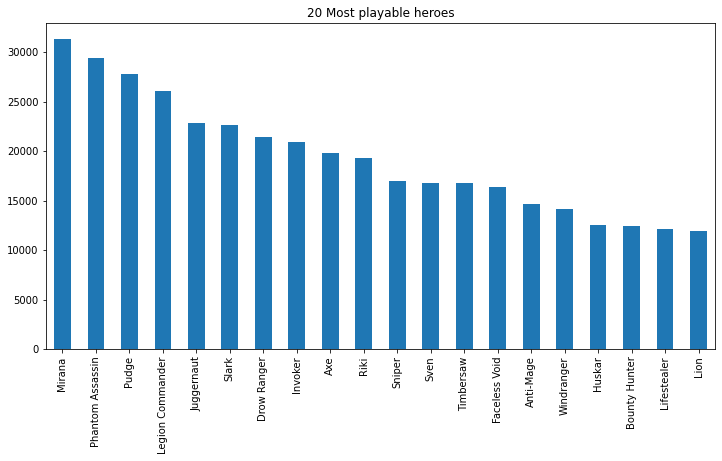

In [30]:
_ = heroes_20.plot(kind='bar', figsize=(12,6), title='20 Most playable heroes')

**Winning rate calculation**
> `WINS` - We substract from each column value of `team`. i.e. if team with this hero won.    
Then we add this matrix to original and take ceil of division of absolute sum by 2.  
> `LOSES` - We substruct absolute value of original matrix with `win_matrix`.   
> `WIN RATE` - `WINS / (WINS + LOSES) * 100`

In [31]:
heroes_mat = htrain_df.to_numpy()
team_col = train_df['team'].to_numpy()[:, np.newaxis]

In [32]:
team_col.shape, heroes_mat.shape

((90944, 1), (90944, 112))

In [33]:
win_mat = abs(heroes_mat + np.tile(team_col, (1, heroes_mat.shape[1]))) // 2
win_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [34]:
lose_mat = abs(heroes_mat) - win_mat
lose_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [35]:
win_rate_df = pd.DataFrame.from_dict({'WINS': win_mat.sum(axis=0), 
                                      'LOSES': lose_mat.sum(axis=0)}).set_index(htrain_df.columns)
win_rate_df['WIN RATE'] = np.round(win_rate_df['WINS'] / (win_rate_df['WINS'] + win_rate_df['LOSES']) * 100, 2)
win_rate_df

,WINS,LOSES,WIN RATE
Anti-Mage,6859,7858,46.61
Axe,10476,9375,52.77
Bane,1119,1369,44.98
Bloodseeker,5860,5674,50.81
Crystal Maiden,5428,4492,54.72
...,...,...,...
Terrorblade,2167,2269,48.85
Phoenix,1939,1838,51.34
Oracle,1120,1468,43.28
Winter Wyvern,1465,1808,44.76


In [36]:
win_rate_20 = win_rate_df['WIN RATE'].sort_values(ascending=False).iloc[:20]

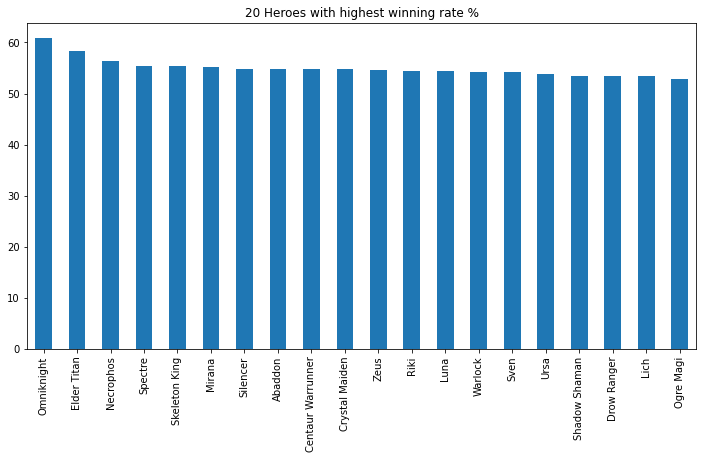

In [37]:
_ = win_rate_20.plot(kind='bar', figsize=(12,6), title='20 Heroes with highest winning rate %')

In [38]:
def calc_win_rate(data_df, heroes_num):
    htrain_df = data_df.iloc[:, 4:]
    
    heroes_mat = htrain_df.to_numpy()
    team_col = data_df['team'].to_numpy()[:, np.newaxis]
    
    win_mat = abs(heroes_mat + np.tile(team_col, (1, heroes_mat.shape[1]))) // 2
    lose_mat = abs(heroes_mat) - win_mat
    
    win_rate_df = pd.DataFrame.from_dict({'WINS': win_mat.sum(axis=0), 
                                      'LOSES': lose_mat.sum(axis=0)}).set_index(htrain_df.columns)
    win_rate_df['WIN RATE'] = np.round(win_rate_df['WINS'] / (win_rate_df['WINS'] + win_rate_df['LOSES']) * 100, 2)
    
    win_rate_num = win_rate_df['WIN RATE'].sort_values(ascending=False).iloc[:heroes_num]

    return win_rate_num

In [39]:
regions_win_rate = list()

for region in train_df['region_name'].unique():
    region_df = train_df.loc[train_df['region_name'] == region]
    
    region_win_rate_df = calc_win_rate(region_df, 5)
    
    regions_win_rate.append((region, region_win_rate_df))

regions = [reg_data[0] for reg_data in regions_win_rate]

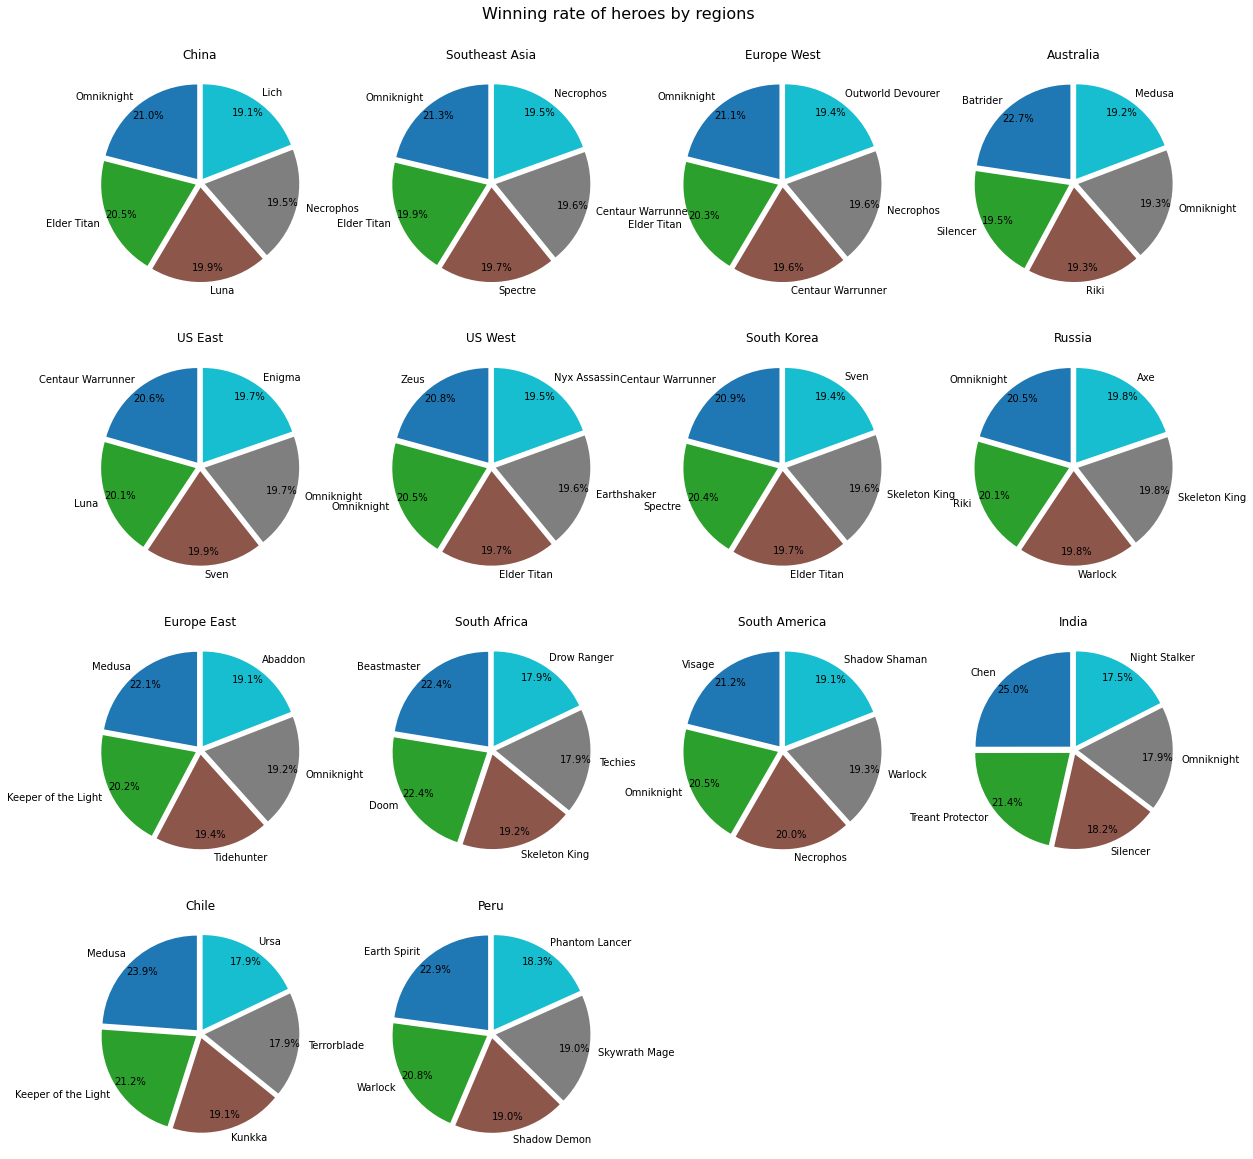

In [40]:
ncols = 4
nrows = int(np.ceil(len(regions_win_rate) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))
fig.suptitle('Winning rate of heroes by regions', y=0.92, fontsize=16)

for (data, ax) in zip(regions_win_rate, axes.flatten()):
    data[1].plot(ax=ax, 
                 kind='pie',
                 cmap='tab10',
                 title=f'{data[0]}', 
                 autopct='%1.1f%%', 
                 startangle=90, 
                 pctdistance=0.85, 
                 explode=[0.05 for i in range(len(data[1]))])
    ax.get_yaxis().set_visible(False)
    
for i in range(1, ncols * nrows - len(regions_win_rate) + 1):
    axes[-1][-i].set_visible(False)

plt.show()

## Frequent team combinations (Apriori algoritm)

In [41]:
!pip install apyori
from apyori import apriori

In [42]:
def calc_pair_win_rate(data_df, h1_id, h2_id):
    filtered_data = data_df.iloc[:, [0, h1_id + 4, h2_id + 4]]
    filtered_data = filtered_data[(filtered_data.iloc[:, [1, 2]] != 0).all(axis=1) & (filtered_data.iloc[:, 1] == filtered_data.iloc[:, 2])]
    
    htrain_df = filtered_data.iloc[:, 1:]
    
    heroes_mat = htrain_df.to_numpy()
    team_col = filtered_data['team'].to_numpy()[:, np.newaxis]

    win_mat = abs(heroes_mat + np.tile(team_col, (1, heroes_mat.shape[1]))) // 2
    
    wins = ((win_mat[:, 0] == win_mat[:, 1]) & (win_mat[:, 0] == 1)).sum()
    win_rate_num = np.round(wins / win_mat.shape[0] * 100, 2)

    return win_rate_num

In [43]:
teams = [tuple(row.nonzero()[0]) for row in (htrain_df == 1).to_numpy()] + \
        [tuple(row.nonzero()[0]) for row in (htrain_df == -1).to_numpy()] 

In [44]:
rules = apriori(teams, min_support=0.005, min_confidence=0.05, min_lift=1.1)
rules = list(rules)
rules.sort(key=lambda x: x.support, reverse=True)

In [45]:
for rule in rules:
    if len(rule.items) > 1:
        print("=====================================")

        for hero_id in rule.items:
            print(f'{new_header[hero_id + 4]}, ', end='')
        print(f'\nProbability: {np.round(rule.support * 100, 2)}%')
        print(f'Winning rate: {calc_pair_win_rate(train_df, *rule.items)}%')

print("=====================================")

Invoker, Faceless Void, 
Probability: 1.2%
Winning rate: 47.32%
Phantom Assassin, Omniknight, 
Probability: 0.82%
Winning rate: 61.24%
Vengeful Spirit, Drow Ranger, 
Probability: 0.82%
Winning rate: 57.2%
Mirana, Shadow Demon, 
Probability: 0.61%
Winning rate: 51.13%
Mirana, Elder Titan, 
Probability: 0.6%
Winning rate: 65.3%
Lifestealer, Spirit Breaker, 
Probability: 0.58%
Winning rate: 52.7%
Dazzle, Huskar, 
Probability: 0.56%
Winning rate: 50.68%
Elder Titan, Faceless Void, 
Probability: 0.51%
Winning rate: 59.29%


In [46]:
train_df

,team,region_name,mode_name,lobbie_type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,-1,China,Captains Mode,Tournament,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Southeast Asia,Captains Mode,Tournament,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,Europe West,Captains Mode,Tournament,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,Southeast Asia,Captains Mode,Tournament,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,Australia,Captains Mode,Tutorial,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,-1,Southeast Asia,Captains Mode,Tutorial,1,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
92646,1,Southeast Asia,Captains Mode,Tournament,0,0,0,0,-1,0,...,1,0,0,0,0,0,0,0,0,0
92647,1,US West,Captains Mode,Tutorial,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92648,-1,Russia,Captains Mode,Tournament,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [47]:
train_df.shape

(90944, 116)

# Predictive Analytics

In [48]:
def prepare_train_test_data(train_df: pd.DataFrame,
                            test_df: pd.DataFrame,
                            target: str,
                            features: list,
                            encoding_method: Literal['one_hot_encoding', 'label_encoding'] = 'label_encoding',
                            encode_target=False):
        """
        Prepearing training and testing data by splitting dataframes to the train and test one.
        Also performing features and target encoding by either One Hot Encoding or Lable Encoding. 
        """    

        X_train = train_df.drop(target, axis=1)
        X_test = test_df.drop(target, axis=1)

        y_train = train_df[[target]]
        y_test = test_df[[target]]
    
        if encode_target:
            y_train, y_test, y_encoders = labels_encoding(y_train, y_test, [target])
    
        y_train = np.array(y_train).ravel()
        y_test = np.array(y_test).ravel()
    
        if encoding_method == 'label_encoding':
            X_train, X_test, X_encoders = labels_encoding(X_train, X_test, features)
            return X_train, X_test, y_train, y_test

        elif encoding_method == 'one_hot_encoding':
            X_train, X_test = one_hot_encoding(X_train, X_test, features)
            return X_train, X_test, y_train, y_test

        else:
            return X_train, X_test, y_train, y_test
            
def labels_encoding(train_data, test_data, features):
    """
    Performs labels encoding for the given training and testing data
    """
    
    label_encoders = {}

    for feature in features:
        label_encoders['train_' + feature] = preprocessing.LabelEncoder()
        label_encoders['test_' + feature] = preprocessing.LabelEncoder()

        label_encoders['train_' + feature].fit(train_data[[feature]])
        label_encoders['test_' + feature].fit(test_data[[feature]])

        train_data[feature] = label_encoders['train_' + feature].transform(train_data[[feature]])
        test_data[feature] = label_encoders['test_' + feature].transform(test_data[[feature]])

    return train_data, test_data, label_encoders


def one_hot_encoding(train_data, test_data, features):
    """
    Performs one hot encoding for the given training and testing data 
    """
    
    train_data_ohe_features = pd.get_dummies(train_data[[*features]])
    test_data_features = pd.get_dummies(test_data[[*features]])
    
    train_data.drop([*features], axis=1, inplace=True)
    test_data.drop([*features], axis=1, inplace=True)

    train_data = pd.concat((train_data, train_data_ohe_features), 1)
    test_data = pd.concat((test_data, test_data_features), 1)

    return train_data, test_data

def show_model_accuracy(X_train, X_test, y_train, y_test):
    print('====================== Accuracy =======================')
    print(f'Training data:\t{model.score(X_train, y_train) * 100:.2f} %')
    print(f'Testing data:\t{model.score(X_test, y_test) * 100 :.2f} %')
    print('=======================================================')    

## The Winning Team Prediction (Logistic Regression Model)

#### Prepearing data with one hot encoding

In [49]:
X_train, X_test, y_train, y_test = prepare_train_test_data(
    train_df,
    test_df,
    target='team',
    features=['mode_name', 'region_name', 'lobbie_type'],
    encoding_method='one_hot_encoding',
    encode_target=True
)

print('Data shape')
print(f"X_train: {X_train.shape} X_test: {y_train.shape}")
print(f"t_train: {X_test.shape} y_test: {y_test.shape}")

Data shape
X_train: (90944, 138) X_test: (90944,)
t_train: (10120, 138) y_test: (10120,)


In [50]:
X_train

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,...,region_name_Russia,region_name_South Africa,region_name_South America,region_name_South Korea,region_name_Southeast Asia,region_name_US East,region_name_US West,lobbie_type_Practice,lobbie_type_Tournament,lobbie_type_Tutorial
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,-1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,-1,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,1,0,0,-1,0,0,0,0,-1,0,...,0,0,0,0,1,0,0,0,0,1
92646,0,0,0,0,-1,0,0,-1,0,0,...,0,0,0,0,1,0,0,0,1,0
92647,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1
92648,0,0,0,0,0,1,0,0,-1,0,...,1,0,0,0,0,0,0,0,1,0


In [51]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [52]:
show_model_accuracy(X_train, X_test, y_train, y_test)

====================== Accuracy =======================
Training data:	60.15 %
Testing data:	59.58 %


## The Winning Team Prediction (XGBoost Model)

#### Prepearing data with label encoding

In [53]:
X_train, X_test, y_train, y_test = prepare_train_test_data(
    train_df,
    test_df,
    target='team',
    features=['mode_name', 'region_name', 'lobbie_type'],
    encoding_method='label_encoding',
    encode_target=True
)

print('Data shape')
print(f"X_train: {X_train.shape} X_test: {y_train.shape}")
print(f"t_train: {X_test.shape} y_test: {y_test.shape}")

Data shape
X_train: (90944, 115) X_test: (90944,)
t_train: (10120, 115) y_test: (10120,)


In [54]:
X_train

,region_name,mode_name,lobbie_type,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,2,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,3,1,0,0,0,1,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
2,4,3,1,0,0,0,1,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,11,3,1,0,0,0,0,0,0,-1,...,-1,0,0,0,0,0,0,0,0,0
4,0,3,2,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,11,3,2,1,0,0,-1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92646,11,3,1,0,0,0,0,-1,0,0,...,1,0,0,0,0,0,0,0,0,0
92647,13,3,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92648,7,3,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Performing Grid Search with Cross Validation to obtain optimal training hyperparametes

In [55]:
"""
Original parameters used for Grid Search. 
Commented to avoid running for extremely long time :)
params = {
    "max_depth": [3, 4, 5, 7],
    "min_child_weight": [1, 2, 3],
    "learning_rate": [0.1, 0.3, 0.4],
    "min_child_weight": [0.95, 1],
    "colsample_bytree": [0.95, 1],
    "n_estimators": [100, 150, 200]
}
"""

params = {
    "max_depth": [4],
    "min_child_weight": [1],
    "learning_rate": [0.4],
    "min_child_weight": [0.95],
    "colsample_bytree": [0.95],
    "n_estimators": [100]
}

model = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, use_label_encoder=False)
model_gs = GridSearchCV(model, param_grid=params, cv=3, scoring="accuracy")
model_gs.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="error", eval_set=[[X_test, y_test]], verbose=0)

print(model_gs.best_params_)

{'colsample_bytree': 0.95, 'learning_rate': 0.4, 'max_depth': 4, 'min_child_weight': 0.95, 'n_estimators': 100}


In [56]:
model = xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, **model_gs.best_params_)
model.fit(X_train, y_train)

[00:55:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.95,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=4,
              min_child_weight=0.95, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [57]:
show_model_accuracy(X_train, X_test, y_train, y_test)

====================== Accuracy =======================
Training data:	63.51 %
Testing data:	58.72 %


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

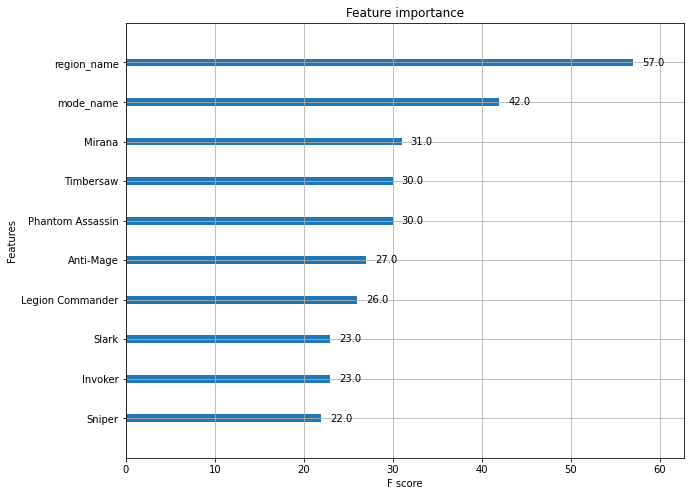

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, ax=ax, max_num_features=10)

<AxesSubplot:>

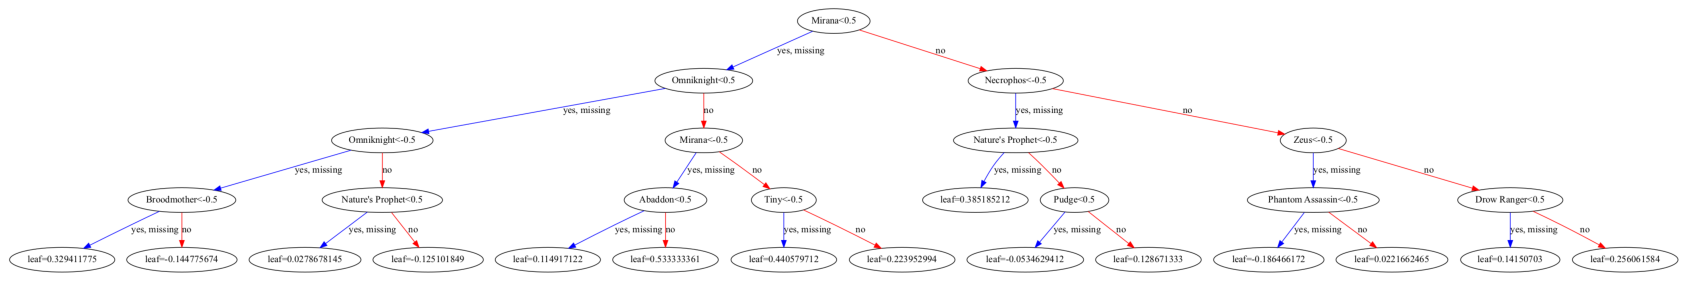

In [59]:
fig, ax = plt.subplots(figsize=(30, 30)) 
xgb.plot_tree(model, ax=ax)

## Mode Name Prediction (XGBoost Model)

#### Prepearing data with label encoding

In [60]:
X_train, X_test, y_train, y_test = prepare_train_test_data(
    train_df,
    test_df,
    target='mode_name',
    features=['region_name', 'lobbie_type'],
    encoding_method='label_encoding',
    encode_target=True
)

print('Data shape')
print(f"X_train: {X_train.shape} X_test: {y_train.shape}")
print(f"t_train: {X_test.shape} y_test: {y_test.shape}")

Data shape
X_train: (90944, 115) X_test: (90944,)
t_train: (10120, 115) y_test: (10120,)


#### XGBoost Model

In [61]:
model = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, use_label_encoder=False)
model.fit(X_train, y_train, verbose=0)

[00:55:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [62]:
show_model_accuracy(X_train, X_test, y_train, y_test)

====================== Accuracy =======================
Training data:	86.06 %
Testing data:	81.41 %


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

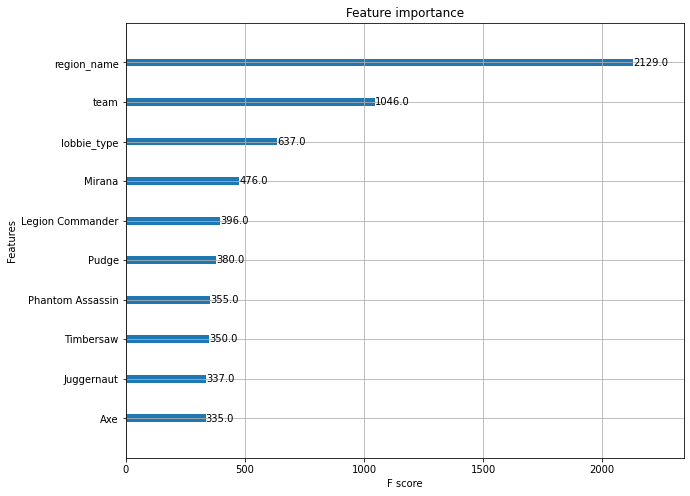

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, ax=ax, max_num_features=10)

# PCA Analysis

In [64]:
def pca_plot(X_train, verbose=True):
    # Normalize data
    x_scaled = StandardScaler().fit_transform(X_train)

    # Build PCA model
    pca = PCA(n_components=2, random_state=47)
    pca_features = pca.fit_transform(x_scaled)

    if verbose:
        print('Shape before PCA:\t', x_scaled.shape)
        print('Shape after PCA:\t', pca_features.shape)

    pca_df = pd.DataFrame(
        data=pca_features, 
        columns=['PC1', 'PC2']
    )
    
    scaler = 1 / (pca_df.max() - pca_df.min())
    pca_df_scaled = pca_df.multiply(scaler)

    # Loadings
    feature_names = X_train.columns[:3]
    loadings = pca.components_[:, :3]

        
    # Draw PCA Plot
    sns.set()
    xs = loadings[0]
    ys = loadings[1]

    facegrid = sns.lmplot(
        x='PC1', 
        y='PC2', 
        data=pca_df_scaled[0:100000:100], # Plot ever 100th element
        fit_reg=False,
        scatter_kws={'alpha': 0.4},
        size=10
    )

    for i, varnames in enumerate(feature_names):
        plt.arrow(
            0, 0, # coordinates of arrow base
            xs[i], # length of the arrow along x
            ys[i], # length of the arrow along y
            color='r', 
            head_width=0.02
            )
        plt.text(xs[i]*1.1, ys[i]*1.1, varnames, color = 'black', ha = 'center', va = 'center')

    xticks = np.linspace(-0.5, 0.5, num=5)
    yticks = np.linspace(-0.5, 0.5, num=5)
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.title('2D Biplot')
    plt.show()

Shape before PCA:	 (90944, 115)
Shape after PCA:	 (90944, 2)


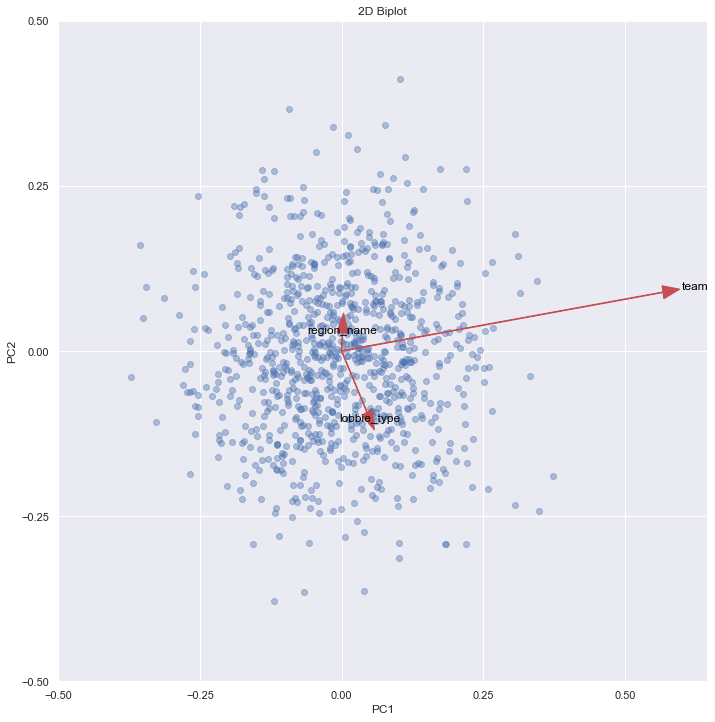

In [65]:
pca_plot(X_train, verbose=True)